In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pytpc
from pytpc.fitting.mcopt_wrapper import Tracker, EventGenerator, PadPlane, Minimizer
from pytpc.constants import *
import pytpc.simulation
import pytpc.tpcplot
import pytpc.vmedata
from pytpc.cleaning import HoughCleaner
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import scipy.signal
import h5py
from scipy.interpolate import UnivariateSpline, interp1d
from scipy.optimize import differential_evolution, minimize, basinhopping, leastsq
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import os
#import cmaps
import yaml
from scipy.fftpack import fft, ifft, fftshift, ifftshift
from copy import copy, deepcopy
from pytpc.utilities import find_exclusion_region, read_lookup_table

from effsim.paramgen import uniform_param_generator
from effsim.paramgen import distribution_param_generator
from effsim.effsim import EventSimulator
from effsim.effsim import NoiseMaker

/home/chen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/chen/anaconda3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
with open('/home/chen/Real Data/config_e15503a_runs_92-104.yml', 'r') as f:
    config = yaml.load(f)

mcfitter = pytpc.fitting.MCFitter(config)

In [4]:
sim = EventSimulator(config)

In [5]:
tilt = config['tilt'] * degrees 
#clock = config['clock']
#beam_en = config['beam_enu0']
padplane = mcfitter.padplane
efield = np.array(config['efield'])
bfield = np.array(config['bfield'])
#tmat = pytpc.utilities.tilt_matrix(-tilt)
# efield_uvw = tmat.dot(efield)
# bfield_uvw = tmat.dot(bfield)
mass_num = config['mass_num']
charge_num = config['charge_num']
gas = pytpc.gases.InterpolatedGas(config['gas_name'], config['gas_pressure'])
beam_enu0 = config['beam_enu0']
beam_charge = config['beam_charge']
beam_mass = config['beam_mass']
max_en = config['tracker_max_en']
vd = np.array(config['vd'])

#beampads = np.fromfile(config['beampads_path'], sep=',', dtype='int')

In [52]:
#Good events for run_0102 are: 357, 689, 765, 896, 714
full = h5py.File('/home/chen/Real Data/clean_run_0102.h5', 'r')
evt_ID = 714
dataset_name = '/clean'
evt_full = full[dataset_name]
xyzs_h5 = evt_full[str(evt_ID)]
cx = 0. #The center of curvature of the track, in mm.
cy = 0.

xyzs = np.array(xyzs_h5)
#print(xyzs)

In [53]:
######cleaning

#xyz, (cu, cv) = mcfitter.preprocess(xyzs, center=(cx, cy))

#pts_only = pd.DataFrame(xyzs[:, 0:3], columns=('x', 'y', 'z'))
#print(pts_only)
#cleaner = HoughCleaner(config)
#cleaned_data = cleaner.clean(pts_only)

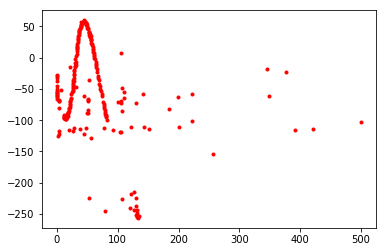

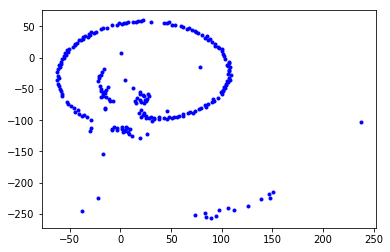

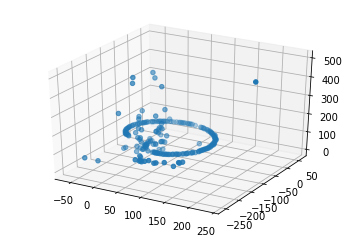

In [54]:
plt.plot(xyzs[:, 2], xyzs[:, 1], 'r.')
plt.show()
plt.plot(xyzs[:, 0], xyzs[:, 1], 'b.')
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyzs[:,0],xyzs[:,1],xyzs[:,2])

In [55]:
xyz, (cu, cv) = mcfitter.preprocess(xyzs[:, 0:5], center=(cx, cy))
print(cu,cv)
mcres, minChis, all_params, good_param_idx = mcfitter.process_event(xyz, cu, cv, return_details=True)

#print(mcres, minChis, all_params, good_param_idx)
print(mcres)

0.0 108.63476435660364
{'x0': 0.0004288044028063359, 'y0': -0.0004498542251079291, 'z0': 0.48131175812105764, 'enu0': 1.0811331276838865, 'azi0': -3.5984559270899896, 'pol0': 1.6009132372664372, 'posChi2': 100.0, 'enChi2': 3.195640603310686, 'vertChi2': 0.007724840794271074, 'lin_scat_ang': 1.703876274893993, 'lin_beam_int': 475.00113768924746, 'lin_chi2': 175944.63375419308, 'rad_curv': 86.72009170919117, 'brho': 0.1469894457899139, 'curv_en': 1.0347964284212796, 'curv_ctr_x': 0.0, 'curv_ctr_y': 108.63476435660364}


In [58]:
#if mcres['azi0'] < 0.:
#    mcres['azi0'] += 2*pi
#if mcres['pol0'] < 0.:
#    mcres['pol0'] += 2*pi
    
evtClean, ctr = sim.make_event(mcres['x0'], mcres['y0'], mcres['z0'], mcres['enu0'], mcres['azi0'], mcres['pol0'])
pyevtClean = sim.convert_event(evtClean)
new_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
#print(new_xyzs)
# drift_vel=-2.54, clock=12.5, 

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


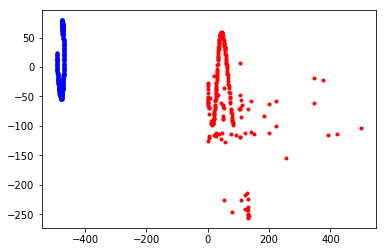

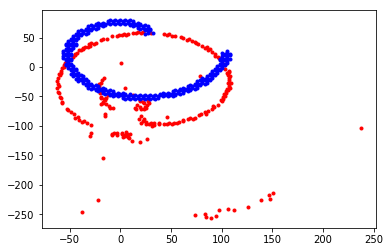

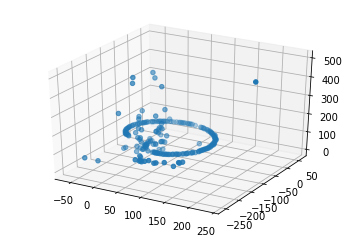

In [59]:
plt.plot(xyzs[:, 2], xyzs[:, 1], 'r.')
plt.plot(new_xyzs[:, 2], new_xyzs[:, 1], 'b.')
plt.show()
plt.plot(xyzs[:, 0], xyzs[:, 1], 'r.')
plt.plot(new_xyzs[:, 0], new_xyzs[:, 1], 'b.')
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyzs[:,0],xyzs[:,1],xyzs[:,2])
plt.show()


In [326]:
good_params = all_params[good_param_idx.astype('int')] #the best points from each iteration, i.e. the ones whose
#                                                       chi2 values are in ``min_chis``
all_params = all_params.reshape((mcfitter.num_iters, mcfitter.num_pts, 6))

[[7.76730367e+01 5.99452284e+00 4.52836450e-02]
 [7.46046950e+01 6.06120829e+00 6.36053189e+00]
 [7.25185591e+01 6.09999875e+00 3.25951618e+00]
 [7.24075127e+01 6.17258297e+00 8.52060833e-01]
 [7.23044390e+01 5.97520211e+00 1.87764625e+00]
 [7.10251322e+01 6.12727762e+00 2.60549088e+00]
 [7.19985121e+01 6.07867630e+00 9.50200770e-02]
 [7.17069625e+01 6.08429813e+00 7.94118647e-01]
 [7.11098278e+01 6.17490441e+00 1.40678423e-01]
 [7.04742570e+01 6.15218631e+00 5.63946116e-01]
 [7.07957471e+01 6.22955041e+00 9.61464436e-02]
 [7.03653467e+01 6.16758306e+00 8.13925584e-02]
 [7.01487968e+01 6.18778988e+00 1.14370837e-01]
 [7.00672449e+01 6.23297834e+00 8.32577042e-03]
 [6.98199521e+01 6.16795388e+00 1.08950873e-01]
 [6.95779798e+01 6.24016271e+00 1.82145637e-01]
 [6.95438106e+01 6.21878867e+00 8.23553417e-02]
 [6.95096594e+01 6.09101344e+00 7.45318484e-02]
 [6.95561196e+01 6.07819712e+00 4.30987609e-02]
 [6.94114862e+01 6.14443502e+00 7.01949167e-02]]


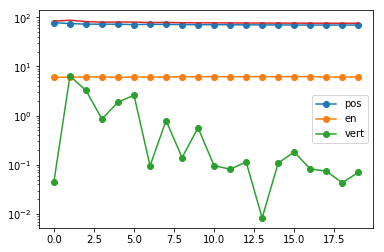

In [327]:
print(minChis)
#print(good_params)
plt.plot(minChis, 'o-')
plt.plot(minChis.sum(1))
plt.semilogy()
plt.legend(('pos', 'en', 'vert'))
#plt.ylim(1e-6,1e3)

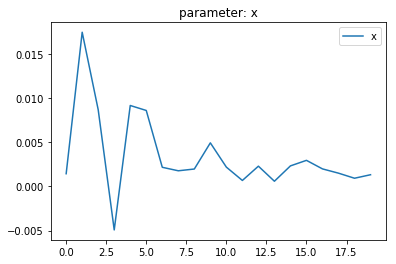

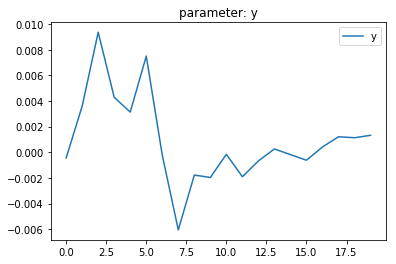

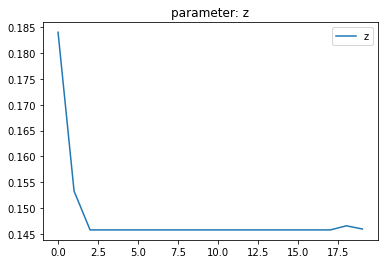

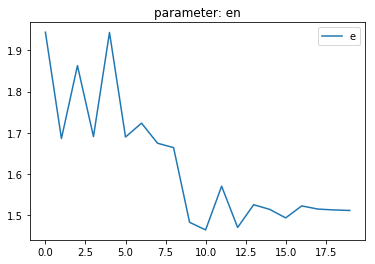

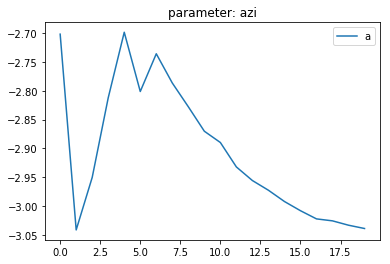

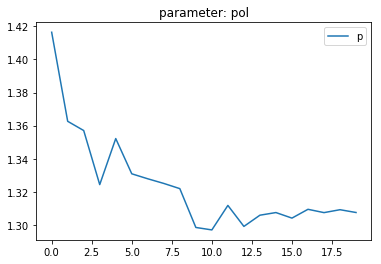

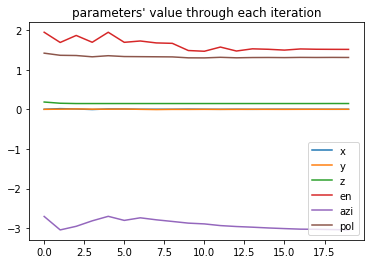

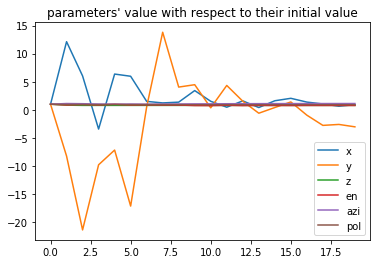

In [328]:
#print(good_params)
params_name = ['x', 'y', 'z', 'en', 'azi', 'pol']

for v, l in zip(good_params.T, range(len(params_name))):
    plt.plot(v, label=l)
    plt.legend(params_name[l])
    plt.title('parameter: ' + str(params_name[l]))
    plt.show()
    
for v, l in zip(good_params.T, params_name):
    plt.plot(v, label=l)
plt.legend(loc=4)
plt.title("parameters' value through each iteration")
plt.show()
    
for v, l in zip(good_params.T, params_name):    
    plt.plot(v / v[0], label=l)
plt.title("parameters' value with respect to their initial value")
plt.legend(loc=4)

TypeError: 'tuple' object is not callable

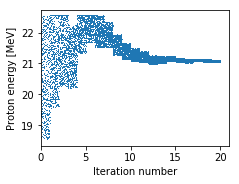

In [117]:

plt.figure(figsize=(3.5, 2.5))
plt.plot(all_params[:, :, 3].ravel(), ',')
plt.xticks(np.arange(0, mcfitter.num_pts * (mcfitter.num_iters + 1), mcfitter.num_pts * 5),
               np.arange(0, mcfitter.num_iters + 1, 5))

plt.xlabel('Iteration number')
plt.ylabel('Proton energy [MeV]')
    
plt.tight_layout(pad=0.5)
plt.subplots_adjust(right=0.9)
    
plt.xlim(0)
plt.ylim(0)


In [118]:
tracker = Tracker(mass_num, charge_num, beam_enu0, beam_mass, beam_charge, gas, efield, bfield, max_en) 
evtgen = EventGenerator(padplane, vd, 12.5, 280e-9, mass_num, 23.0, 500, 120e-15, tilt, 0.1e-3) 


num_iters = [5, 10, 15, 20]
num_pts = [100, 200, 300, 400, 500] #repeat(200)
red_factor = [0.5, 0.6, 0.7, 0.8, 0.9]

#for n, p, r in zip(num_iters, num_pts, red_factor):
#    minimizer = Minimizer(tracker, evtgen, num_iters, num_pts, red_factor)

allctrs = []
for n, p, r in zip(num_iters, num_pts, red_factor):
    ctrs = []
    for i in range(1):
        mcres, minChis, all_params, good_param_idx = mcfitter.process_event(xyz, cu, cv, return_details=True)
        good_params = all_params[good_param_idx.astype('int')]
        ctrs.append(pd.DataFrame(good_params.T, index=('x', 'y', 'z', 'en', 'azi', 'pol')))

    ctrs = pd.concat(ctrs, axis=1).T
    ctrs['num_iters'] = n
    ctrs['num_pts'] = p
    ctrs['red_factor'] = r

    allctrs.append(ctrs)

In [17]:
print(allctrs)

[           x         y         z        en       azi       pol  num_iters  \
0   0.001473  0.001066 -0.796789  0.268262 -3.485968  1.421802          5   
1   0.000655  0.002163 -0.832835  1.361366 -3.467274  1.548711          5   
2   0.000294  0.000149 -0.854964  1.344857 -3.332537  1.588002          5   
3  -0.001548  0.000601 -0.865954  0.440030 -3.296858  1.492824          5   
4  -0.000138 -0.000327 -0.868208  0.602742 -3.334114  1.589574          5   
5  -0.000020  0.000544 -0.868208  0.206567 -3.246402  1.547937          5   
6   0.000133 -0.000064 -0.868208  0.395105 -3.181191  1.612973          5   
7   0.000296 -0.000242 -0.867554  0.067408 -3.285595  1.645948          5   
8   0.000332  0.000407 -0.868208  0.296734 -3.325377  1.617639          5   
9   0.000110 -0.000131 -0.864298  0.467446 -3.328146  1.583098          5   
10  0.000269 -0.000263 -0.868208  0.678626 -3.281634  1.592297          5   
11 -0.000149  0.000022 -0.868208  0.712741 -3.281040  1.573916          5  